### 1. Importing Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


###2. Importing and Exploration of the dataset

In [7]:
# Reading the file with ISO-8859-1 encoding
df = pd.read_csv("/content/MathE dataset (4).csv",delimiter=';',encoding='ISO-8859-1')

# Display the first 5 rows
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


In [8]:
# Basic info about the dataset
info = df.info()

# Summary statistics for numerical columns
summary_stats = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

# Get unique value counts for categorical columns
categorical_summary = df.select_dtypes(include='object').nunique()

# Check for duplicates
duplicates = df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9546 entries, 0 to 9545
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Student ID       9546 non-null   int64 
 1   Student Country  9546 non-null   object
 2   Question ID      9546 non-null   int64 
 3   Type of Answer   9546 non-null   int64 
 4   Question Level   9546 non-null   object
 5   Topic            9546 non-null   object
 6   Subtopic         9546 non-null   object
 7   Keywords         9546 non-null   object
dtypes: int64(3), object(5)
memory usage: 596.8+ KB


### **Dataset Overview**
- The dataset has **9,546 rows** and **8 columns**.
- It includes both **numeric** and **categorical** data:
  - Numeric: `Student ID`, `Question ID`, `Type of Answer`
  - Categorical: `Student Country`, `Question Level`, `Topic`, `Subtopic`, `Keywords`




In [9]:
summary_stats

,Student ID,Question ID,Type of Answer
count,9546.000000,9546.000000,9546.000000
mean,775.402263,478.912319,0.468259
std,460.590559,249.244061,0.499018
min,26.000000,77.000000,0.000000
25%,380.000000,323.000000,0.000000
50%,885.000000,428.000000,0.000000
75%,1219.000000,571.000000,1.000000
max,1565.000000,1549.000000,1.000000


In [10]:
df[['Student ID', 'Question ID']].nunique()

,0
Student ID,372
Question ID,833




### **Summary of Numeric Columns**
- **`Student ID`** and **`Question ID`** have wide ranges, there are 372 unique students and 833 unique questions in the dataset.
- **`Type of Answer`** is binary (0 or 1), indicating likely incorrect (0) or correct (1) responses.
- The **mean of `Type of Answer`** is ~0.47 → slightly more incorrect answers than correct ones.
  


In [11]:
missing_values

,0
Student ID,0
Student Country,0
Question ID,0
Type of Answer,0
Question Level,0
Topic,0
Subtopic,0
Keywords,0



### **Missing Data**
- **No missing values** in any column.

In [12]:
categorical_summary

,0
Student Country,8
Question Level,2
Topic,14
Subtopic,24
Keywords,365


### **Categorical Columns Summary**
Here’s how diverse each of these columns is:
- **Student Country:** 8 unique countries
- **Question Level:** 2 levels (mostly "Basic")
- **Topic:** 14 unique topics
- **Subtopic:** 24 unique subtopics
- **Keywords:** 365 different keyword sets.


In [13]:
duplicates

np.int64(2083)

### **Duplicate Rows**
- Found **2,083 duplicate entries**


In [14]:
# Count the number of unique Student IDs
unique_student_count = df['Student ID'].nunique()

# Also show frequency of each Student ID (to see if some repeated a lot)
student_id_counts = df['Student ID'].value_counts()

unique_student_count, student_id_counts.head()


(372,
 Student ID
 1220    727
 91      321
 168     221
 955     160
 913     142
 Name: count, dtype: int64)

There are **372 unique students** in the dataset.

- Student ID `1220`: 727 attempts  
- Student ID `91`: 321 attempts  
- Student ID `168`: 221 attempts  
- Student ID `955`: 160 attempts  
- Student ID `913`: 142 attempts  

In [15]:
# Count 0s and 1s for each (Student ID, Question ID) pair
answer_distribution = df.groupby(['Student ID', 'Question ID'])['Type of Answer'].value_counts().unstack(fill_value=0).reset_index()

# Rename columns for clarity
answer_distribution.columns.name = None
answer_distribution = answer_distribution.rename(columns={0: 'Count of 0s', 1: 'Count of 1s'})
# Add a total attempts column
answer_distribution['Total Attempts'] = answer_distribution['Count of 0s'] + answer_distribution['Count of 1s']

# Sort to find the entries with the highest number of attempts
most_attempted = answer_distribution.sort_values(by='Total Attempts', ascending=False)

most_attempted.head()



,Student ID,Question ID,Count of 0s,Count of 1s,Total Attempts
5468,1220,452,7,17,24
5473,1220,459,11,12,23
5459,1220,433,8,14,22
5460,1220,434,9,13,22
5462,1220,436,4,18,22



Multiple entries for the same **Student ID** and **Question ID** are **not removed**, as they represent **reattempts**, not true duplicates.  
These repeated attempts offer valuable insights into student behavior, such as:

- Learning progression
- Engagement and persistence
- Topic-level difficulty

In [16]:
# Count number of identical records across all columns
df_updated = df.groupby(df.columns.tolist()).size().reset_index(name='Record Count')
df_updated.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords,Record Count
0,26,Portugal,88,1,Basic,Linear Algebra,Linear Systems,"Inconsistent system,Square linear system,Solut...",1
1,26,Portugal,92,1,Basic,Linear Algebra,Linear Systems,"Consistent system,Square linear system,Inconsi...",1
2,26,Portugal,146,1,Basic,Differential Equations,Differential Equations,Separable variables equation,2
3,26,Portugal,156,1,Basic,Differential Equations,Differential Equations,Linear differential equation,1
4,26,Portugal,157,1,Basic,Differential Equations,Differential Equations,"Homogeneous equation,Cauchy problem",1


In [17]:
df_updated_ = df.groupby(df.columns.tolist()).size().reset_index(name='Record Count')
df_updated_.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords,Record Count
0,26,Portugal,88,1,Basic,Linear Algebra,Linear Systems,"Inconsistent system,Square linear system,Solut...",1
1,26,Portugal,92,1,Basic,Linear Algebra,Linear Systems,"Consistent system,Square linear system,Inconsi...",1
2,26,Portugal,146,1,Basic,Differential Equations,Differential Equations,Separable variables equation,2
3,26,Portugal,156,1,Basic,Differential Equations,Differential Equations,Linear differential equation,1
4,26,Portugal,157,1,Basic,Differential Equations,Differential Equations,"Homogeneous equation,Cauchy problem",1


- To count how many times the exact same response was submitted, treating them as reattempts.  
- This helps understand repeated behavior and reduces bias in clustering by avoiding overrepresentation.


In [18]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7463 entries, 0 to 7462
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Student ID       7463 non-null   int64 
 1   Student Country  7463 non-null   object
 2   Question ID      7463 non-null   int64 
 3   Type of Answer   7463 non-null   int64 
 4   Question Level   7463 non-null   object
 5   Topic            7463 non-null   object
 6   Subtopic         7463 non-null   object
 7   Keywords         7463 non-null   object
 8   Record Count     7463 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 524.9+ KB


In [19]:
df_updated.describe()

,Student ID,Question ID,Type of Answer,Record Count
count,7463.000000,7463.000000,7463.000000,7463.000000
mean,744.538925,481.125151,0.459065,1.279110
std,461.122306,257.731913,0.498355,1.016588
min,26.000000,77.000000,0.000000,1.000000
25%,375.000000,319.000000,0.000000,1.000000
50%,840.000000,428.000000,0.000000,1.000000
75%,1146.000000,613.500000,1.000000,1.000000
max,1565.000000,1549.000000,1.000000,18.000000


### **Updated Dataset Summary**
- **Total Records (Grouped)**: 7,463  
- **Most Frequent Country**: Portugal (4,701 responses)  
- **Most Common Question Level**: Basic (6,053 records)  
- **Most Frequent Topic**: Linear Algebra  
- **Most Common Subtopic**: Vector Spaces  
- **Most Used Keyword**: "Simplify expressions" (333 times)  
- **Correct Answer Rate**: ~46% (based on `Type of Answer` mean = 0.459)  
- **Reattempts Count**: Max of 18 repeated identical responses for one record  
- **No missing values** in any column  


# Visualization

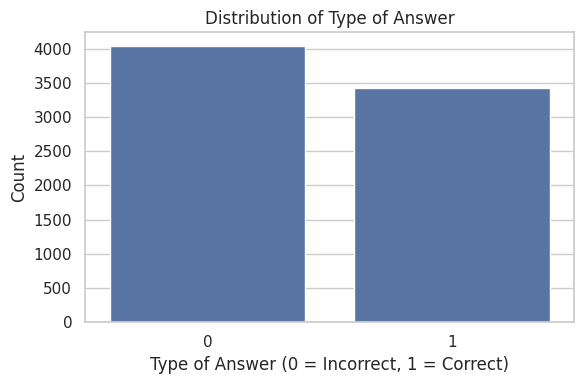

In [20]:
# Distribution of Type of Answer
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x="Type of Answer", data=df_updated)
plt.title("Distribution of Type of Answer")
plt.xlabel("Type of Answer (0 = Incorrect, 1 = Correct)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



### ** Distribution of Type of Answer**  
This chart shows how often students answered questions correctly (`1`) or incorrectly (`0`).  
You can see a slight **imbalance toward incorrect answers**, suggesting that some questions may be challenging or students may need more support.




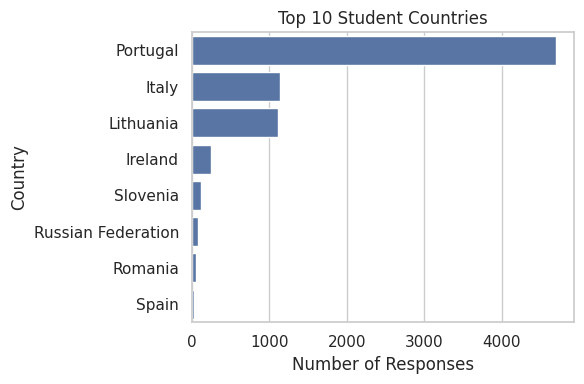

In [21]:

# Top Student Countries
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
top_countries = df_updated['Student Country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Student Countries")
plt.xlabel("Number of Responses")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


### **Top Student Countries**  
Portugal dominates the dataset, contributing the majority of responses.  
This is important for clustering, as country-based clusters might reflect **geographic bias** unless adjusted or weighted.

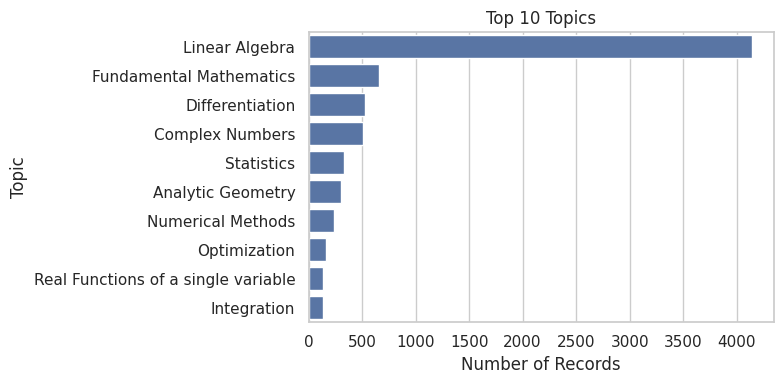

In [22]:
# Top Topics
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
top_topics = df_updated['Topic'].value_counts().head(10)
sns.barplot(x=top_topics.values, y=top_topics.index)
plt.title("Top 10 Topics")
plt.xlabel("Number of Records")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

### **Top 10 Topics**  
"Linear Algebra" is by far the most common topic, followed by Statistics and Real Functions.  
This could **skew clustering** results if topics are not balanced or normalized — students might be grouped by topic frequency rather than skill.

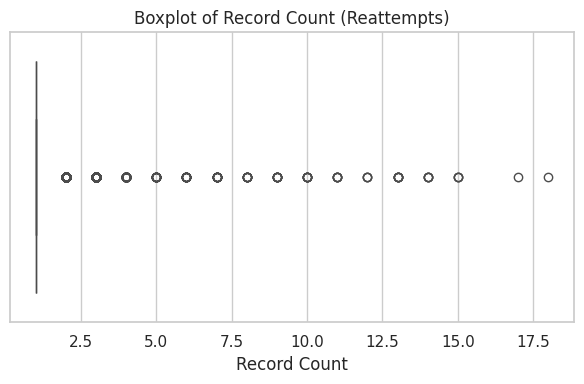

In [23]:
# Boxplot of Record Count
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_updated["Record Count"])
plt.title("Boxplot of Record Count (Reattempts)")
plt.xlabel("Record Count")
plt.tight_layout()
plt.show()

### **Boxplot of Record Count (Reattempts)**  
Most students answered a question once, but a few reattempted up to **18 times**.  
These high values are **outliers**, and may need special handling in clustering to avoid giving too much weight to persistent attempts.

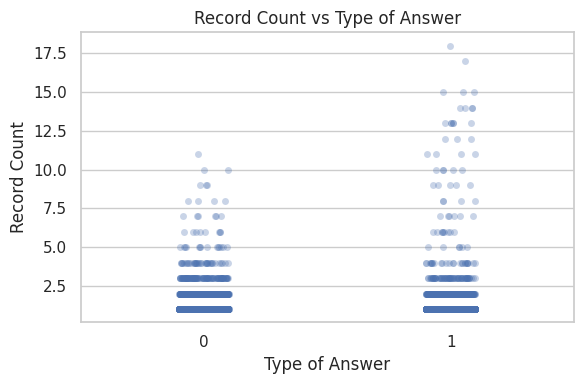

In [24]:
# Record Count vs Type of Answer (scatter)
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.stripplot(x="Type of Answer", y="Record Count", data=df_updated, jitter=True, alpha=0.3)
plt.title("Record Count vs Type of Answer")
plt.xlabel("Type of Answer")
plt.ylabel("Record Count")
plt.tight_layout()
plt.show()

### **Record Count vs Type of Answer**  
This plot shows how many times a question was reattempted and whether it ended in a correct or incorrect answer.  
Some students needed several tries to get it right — which reflects **learning behavior**, not noise, and should be preserved for regression analysis.

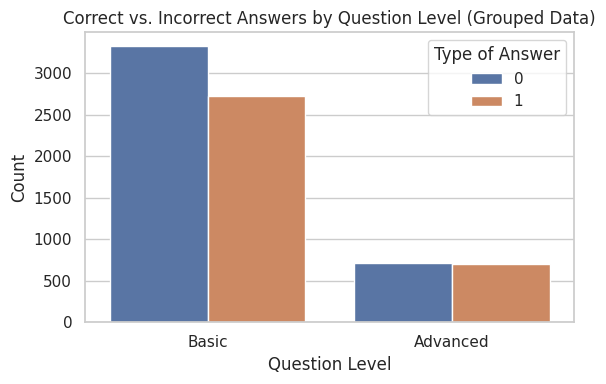

In [25]:
# Type of Answer by Question Level (from df_updated)
plt.figure(figsize=(6, 4))
sns.countplot(data=df_updated, x='Question Level', hue='Type of Answer')
plt.title("Correct vs. Incorrect Answers by Question Level (Grouped Data)")
plt.xlabel("Question Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### **Correct vs. Incorrect Answers by Question Level (Grouped Data)**  
Even after grouping reattempts, **Basic-level questions** still dominate the dataset.  
Correct answers are more frequent at the basic level, confirming that **question difficulty continues to impact performance** across attempts.

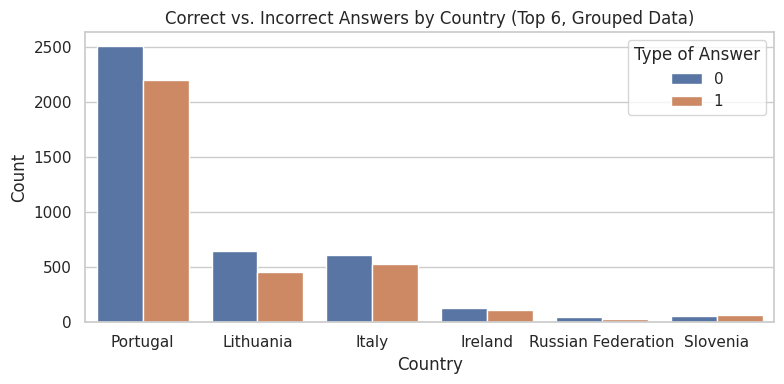

In [26]:
# Type of Answer by Student Country (Top 6) - from df_updated
plt.figure(figsize=(8, 4))
top_countries_updated = df_updated['Student Country'].value_counts().nlargest(6).index
filtered_df_updated = df_updated[df_updated['Student Country'].isin(top_countries_updated)]
sns.countplot(data=filtered_df_updated, x='Student Country', hue='Type of Answer')
plt.title("Correct vs. Incorrect Answers by Country (Top 6, Grouped Data)")
plt.xlabel("Country")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### **Correct vs. Incorrect Answers by Country (Top 6, Grouped Data)**  
The top 6 countries still show **Portugal** leading by volume.  
Performance is fairly balanced across most countries, but slight differences suggest that **country-level trends remain consistent even after removing repeated identical attempts**.

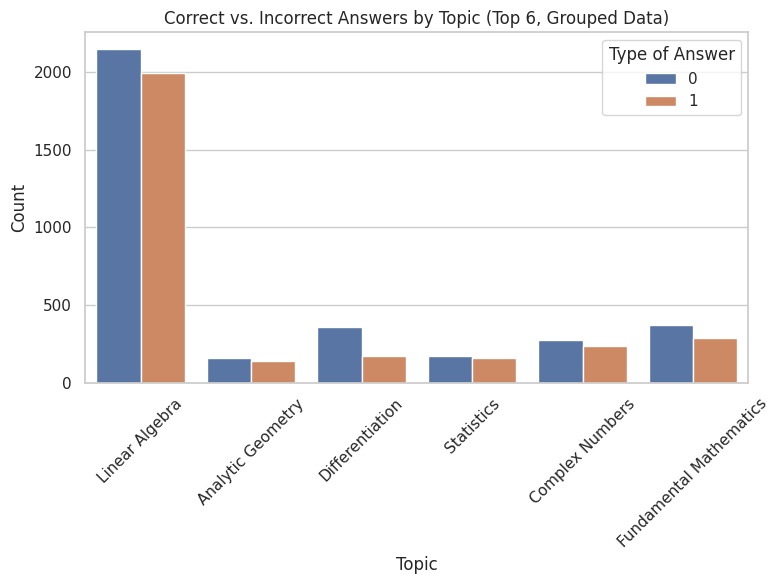

In [27]:
# Type of Answer by Topic (Top 6) - from df_updated
plt.figure(figsize=(8, 6))
top_topics_updated = df_updated['Topic'].value_counts().nlargest(6).index
filtered_topics_updated = df_updated[df_updated['Topic'].isin(top_topics_updated)]
sns.countplot(data=filtered_topics_updated, x='Topic', hue='Type of Answer')
plt.title("Correct vs. Incorrect Answers by Topic (Top 6, Grouped Data)")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Correct vs. Incorrect Answers by Topic (Top 6, Grouped Data)**  
"Linear Algebra" and "Statistics" continue to be the most common topics.  
Grouped data shows a clearer split in performance — for example, **Linear Algebra** tends to have more correct answers, while others like **Statistics** may need attention due to higher incorrect response rates.

In [28]:
#Feature Engineering
df_updated['Was Reattempted'] = df_updated['Record Count'].apply(lambda x: 1 if x > 1 else 0)
df_updated['Is Advanced'] = df_updated['Question Level'].astype(str).str.lower().eq('advanced').astype(int)
df_updated['Record Count'] = df_updated['Record Count'].apply(lambda x: min(x, 10))  # Cap outliers

###Feature Engineering Summary

- **Was Reattempted**: A binary column indicating whether a question was attempted more than once (`1`) or not (`0`).  
- **Is Advanced**: A binary column derived from `Question Level`, where `1` represents 'Advanced' and `0` represents 'Basic'.  
- **Record Count**: Outlier values were capped at a maximum of 10 to reduce their influence on clustering and modeling.

These engineered features help capture student effort, question difficulty, and control outlier impact in the analysis.


In [29]:
#Drop unnecessary or high-cardinality columns
df_model = df_updated.drop(columns=['Student ID','Keywords','Question Level'])

###Dropping Unnecessary or High-Cardinality Columns

- **Student ID** was removed because it's a unique identifier and does not contribute to meaningful patterns for clustering or prediction.
- **Keywords** was excluded due to its high cardinality and complexity, which would require separate text preprocessing.
- **Question Level** was dropped after transforming it into the binary `Is Advanced` feature.

This step ensures that only relevant and model-friendly features are retained for further analysis.


In [30]:
#Encode categorical features using Label Encoding
label_encoders = {}
for col in ['Student Country', 'Topic', 'Subtopic']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

##Normalize numeric features
#numeric_features = ['Record Count']
#df_model[numeric_features] = StandardScaler().fit_transform(df_model[numeric_features])

###Encoding and Normalizing Features

- **Label Encoding** was applied to `Student Country`, `Topic`, and `Subtopic` to convert categorical text into numeric values that clustering algorithms can understand.
- **StandardScaler** was used to normalize the `Record Count` column, bringing its values to a common scale.  
  This helps ensure that features contribute equally during distance-based calculations like K-Means.

These steps prepare the data for effective and unbiased clustering by converting and scaling key features.


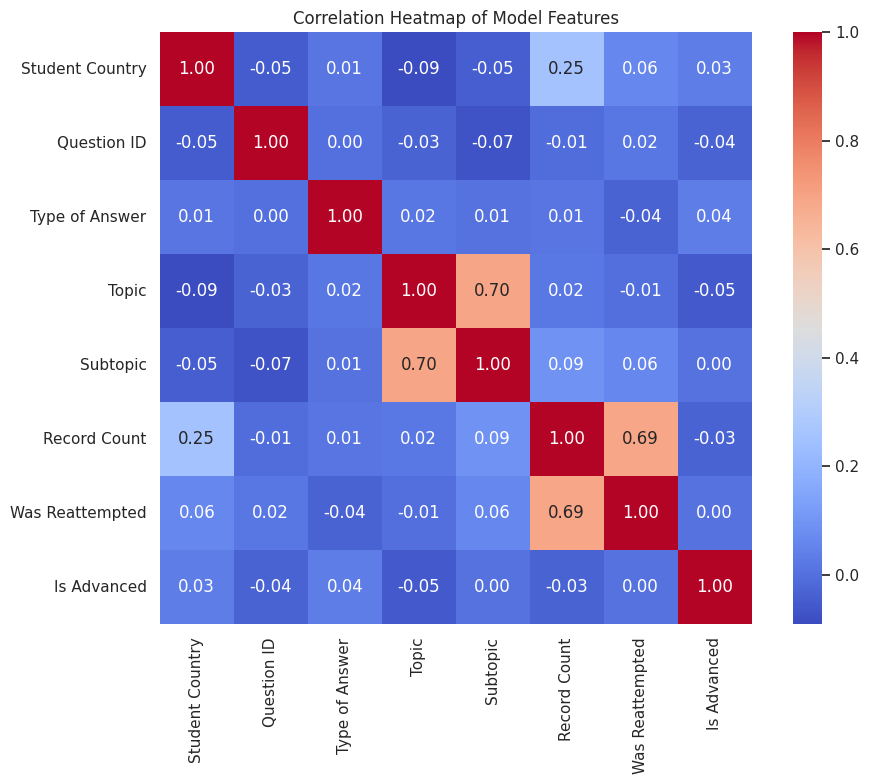

In [31]:
# Correlation matrix
correlation_matrix = df_model.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Model Features')
plt.tight_layout()
plt.show()

In [32]:
df_model

,Student Country,Question ID,Type of Answer,Topic,Subtopic,Record Count,Was Reattempted,Is Advanced
0,3,88,1,7,14,1,0,0
1,3,92,1,7,14,1,0,0
2,3,146,1,2,5,2,1,0
3,3,156,1,2,5,1,0,0
4,3,157,1,2,5,1,0,0
...,...,...,...,...,...,...,...,...
7458,3,685,0,11,12,1,0,0
7459,3,686,0,11,12,1,0,0
7460,3,732,0,6,11,1,0,1
7461,3,905,1,2,5,1,0,1


# **Clustering**

Transformed data shape: (7463, 8)


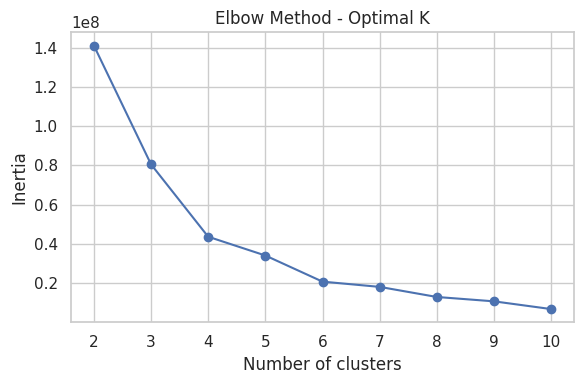

In [33]:
#Apply clustering
X_preprocessed = df_model.drop(columns=['Cluster'], errors='ignore')  # ensure no existing 'Cluster' column

# Final shape check
print("Transformed data shape:", X_preprocessed.shape)

#Clustering Analysis
# Determine the optimal number of clusters using Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_preprocessed)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()



###Clustering Analysis (Elbow Method)

- The preprocessed dataset was prepared for clustering by removing the `Cluster` column (if present).
- The **Elbow Method** was used to find the optimal number of clusters by plotting the **inertia** (within-cluster sum of squares) for `k` values ranging from 2 to 10.
- The point where the curve **starts to flatten** (the "elbow") indicates the ideal number of clusters.
- Based on the plot, we chose to use **4 clusters** for K-Means, balancing interpretability and segmentation quality.

This ensures meaningful groupings of student behavior or response patterns.


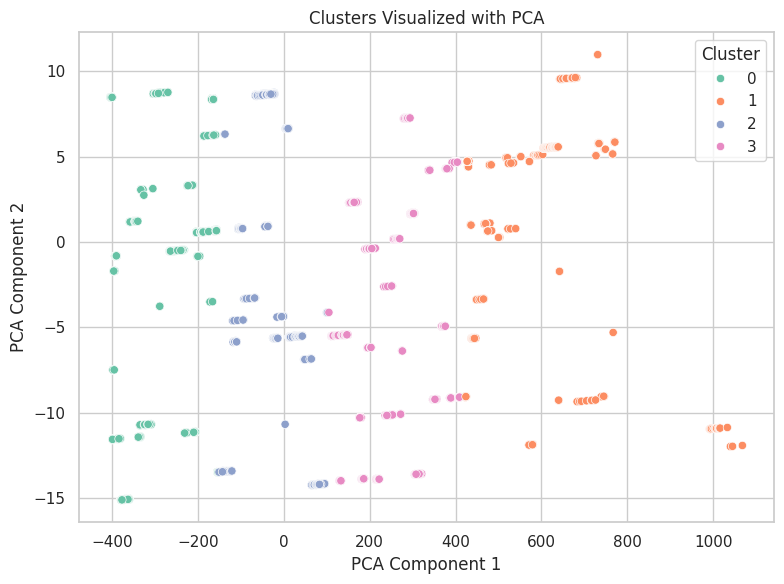

Silhouette Score for k=4: 0.58


In [45]:
#Fit final KMeans with optimal K (choose based on elbow curve, here we assume k=4)
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42)
cluster_labels = kmeans.fit_predict(X_preprocessed)

#Add cluster labels to the original data
df_model['Cluster'] = cluster_labels

#Visualize clusters using PCA (for 2D representation)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set2')
plt.title('Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#Optional - Silhouette Score to evaluate clustering
score = silhouette_score(X_preprocessed, cluster_labels)
print(f'Silhouette Score for k={k_final}: {score:.2f}')


###Final Clustering and Visualization

- Applied **K-Means clustering** using `k = 4` as determined by the elbow method.
- Assigned each record a **cluster label** and added it back to the dataset.
- Used **PCA (Principal Component Analysis)** to reduce dimensionality and visualize the clusters in 2D space.
- Each point in the scatter plot represents a record, colored by its cluster group.

Additionally, the **Silhouette Score** was calculated to assess clustering quality.  
It provides a measure of how well-separated the clusters are. Our final score was: 0.58



In [35]:
df_model

,Student Country,Question ID,Type of Answer,Topic,Subtopic,Record Count,Was Reattempted,Is Advanced,Cluster
0,3,88,1,7,14,1,0,0,0
1,3,92,1,7,14,1,0,0,0
2,3,146,1,2,5,2,1,0,0
3,3,156,1,2,5,1,0,0,0
4,3,157,1,2,5,1,0,0,0
...,...,...,...,...,...,...,...,...,...
7458,3,685,0,11,12,1,0,0,3
7459,3,686,0,11,12,1,0,0,3
7460,3,732,0,6,11,1,0,1,3
7461,3,905,1,2,5,1,0,1,1


# **Linear Regressison**

In [36]:
# Stratified sampling using combined Country, Topic, and Type of Answer
df_model['Stratify_Key'] = df_model['Student Country'].astype(str) + "_" + df_model['Topic'].astype(str) + "_" + df_model['Type of Answer'].astype(str)

# Filter out combinations that appear only once
group_counts = df_model['Stratify_Key'].value_counts()
valid_keys = group_counts[group_counts > 1].index
df_stratified = df_model[df_model['Stratify_Key'].isin(valid_keys)]

# Prepare features and target
X = df_stratified.drop(columns=['Type of Answer', 'Stratify_Key'])
y = df_stratified['Type of Answer']
stratify_key = df_stratified['Stratify_Key']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify_key, random_state=42
)

# Check resulting class distribution
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train target distribution:
 Type of Answer
0    0.540396
1    0.459604
Name: proportion, dtype: float64
Test target distribution:
 Type of Answer
0    0.541555
1    0.458445
Name: proportion, dtype: float64


In the **exploratory data analysis (EDA)** section, several visualizations—such as the **countplot of `Type of Answer`**, and bar charts showing **answer distributions by Country and Topic**—revealed key imbalances in the dataset:

- A **slightly higher number of incorrect answers (Type of Answer = 0)**.
- **Overrepresentation of certain countries** (e.g., Portugal, Ireland).
- **Topic imbalance**, where subjects like Statistics and Geometry appeared more frequently than others.

To address these, we applied **stratified sampling based on a combined key**:  
`Student Country + Topic + Type of Answer`.

This ensures that the **distribution of answer types within each (Country, Topic) group** is preserved across both training and testing sets. As a result, we avoid biased splits and ensure more reliable model evaluation based on real-world patterns.


In [37]:
#Apply Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [38]:
#Evaluate model performance
rmse = mean_squared_error(y_test, y_pred,) ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

RMSE: 0.4976
R-squared: 0.0029


The RMSE is close to 0.5, indicating prediction is near random chance, and the R² score is nearly zero, showing the model explains less than 1% of the target's variance. This confirms poor model fit.

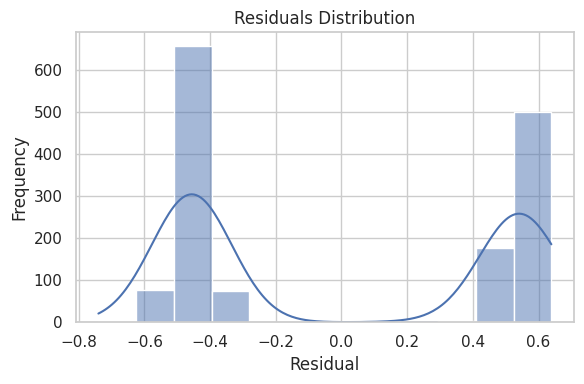

In [39]:
#Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The residuals distribution below shows a clear bimodal shape, suggesting the model often either overpredicts or underpredicts.